<a href="https://colab.research.google.com/github/dpostolovski/eeg_is/blob/master/FINAL%20v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
  <img alt="FINKI **LOGO**" height="auto" src="https://www.finki.ukim.mk/Content/dataImages/downloads/logo-large-500x500_2.png" hspace="10px" vspace="0px">
  <h1>
    Интелигентни системи - Лабораториска вежба
  </h1>

  <h3><i>Група 5</i></h3>
  <h4><i>Дамjан Постоловски, Стефан Тодоровски, Ангела Кралевска, Иван Крстев, Мариjа Величковска</i></h2>
</center>

---



# (1) Подготовка на околината

In [ ]:
#@title 1.1 Монтирање на Google Drive податочниот систем
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#@title 1.2 Инсталирање, вчитување и иницијализација на потребните библиотеки
!pip install mne 
!pip install termcolor

%tensorflow_version 1.12.0

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import mne
from mne.preprocessing import ICA

from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import to_categorical as to_cat
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from scipy.io import loadmat
from collections import Counter
from termcolor import colored

%cd drive/My\ Drive/Интелигентни\ Системи
from EEGModels import DeepConvNet, EEGNet

!mkdir saved_models

K.set_image_data_format('channels_first')

# (2) Иницијализација на функции и константи

In [44]:
#@title 2.1 Иницијализација на константи
PARTICIPANT_START = 3 #@param {type:"integer"}
PARTICIPANT_END = 5 #@param {type:"integer"}
NUM_BATCH_SIZE=100 #@param {type:"integer"}
NUM_EPOCHS=150 #@param {type:"integer"}
#@markdown PARTICIPANT_START е константа која означува од кој учесник треба да почнеме да го тренираме моделот. 

#@markdown PARTICIPANT_END е константа која означува до кој учесник треба да тренира моделот.

#@markdown NUM_BATCH_SIZE и NUM_EPOCHS се константи кои се користат за учење на моделот и го означуваат бројот на примероци (batch) по епохи (epochs).


CH_NAMES = ["C3", "Cz", "C4", "CPz", "P3", "Pz", "P4", "POz"]
CH_TYPES = ['eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg']
MNE_INFO = mne.create_info(ch_names=CH_NAMES, sfreq=250, ch_types=CH_TYPES)

## 2.2 Иницијализација на функции кои ќе ги користиме
1. load_mat_data - ги вчитува .mat податоците.
2. load_txt_data - ги вчитува .txt податоците.
3. load_data - ги повикува претходните две функции и ги вчитува податоците за даден учесник.
4. reshape - ја трансформира низата да биде компатибилна со DeepConvNet
5. load_runs_per_block - го вчитува бројот на обиди во блоковите за тест податоците
6. print_test_data_info - печатење карактеристики на вчитаните тест податоци





In [33]:
def load_mat_data(folder_path, file_name, mode = 'Train'):
    """
        Load and concatenate train mat data from all three sessions.

        :param folder_path: path to the participant data
        :param file_name: the name of the mat file to be loaded (without .mat extension)
        :param mode: Train or Test data 
        :return: numpy array containing the mat data
    """
    data = np.empty(0)
    for session in range(1, 4):  # Итерација низ секоја сесија
        path = folder_path + '/S' + format(session, '02') + '/' + mode + '/' + file_name + '.mat'
        temp = loadmat(path)[file_name]
        if data.size != 0:
            data = np.concatenate((data, temp), axis=2)
        else:
            data = np.array(temp)
    return data


def load_txt_data(folder_path, file_name, mode = 'Train'):
    """
        Load and concatenate txt data from all three sessions.

        :param folder_path: path to the participant data
        :param file_name: the name of the file to be loaded
        :param mode: Train or Test data 
        :return: numpy array containing the wanted data
    """
    data = np.empty(0)
    for session in range(1, 4):  # Итерација низ секоја сесија
        path = folder_path + '/S' + format(session, '02') + '/' + mode + '/' + file_name
        with open(path, "r") as file:
            temp = file.read().splitlines()
            if file_name == 'trainLabels.txt':
                temp = np.repeat(temp, 8 * 10)
            if data.size != 0:
                data = np.concatenate((data, temp))
            else:
                data = np.array(temp)
    return data


def load_data(participant):
    """
        Load data for the given participant.

        :param participant: Participant number (1-15)
        :return: train_data, train_labels, train_events, train_targets
    """
    print("Вчитување податоци од испитниот примерок (учесник) " + str(participant) + '...')
    path_to_data = 'Data/SBJ' + format(participant, '02')

    train_data = load_mat_data(path_to_data, 'trainData')
    train_labels = load_txt_data(path_to_data, 'trainLabels.txt')
    train_events = load_txt_data(path_to_data, 'trainEvents.txt')
    train_targets = load_txt_data(path_to_data, 'trainTargets.txt')

    train_labels = train_labels.astype(np.int); train_labels = train_labels-1
    train_events = train_events.astype(np.int); train_events = train_events-1
    train_targets = train_targets.astype(np.int);

    print("Податоците од испитниот примерок (учесник) " + str(participant) + " се вчитани.\n")
    return train_data, train_labels, train_events, train_targets


def load_test_data(participant):
    """
        Load test data for the given participant.

        :param participant: Participant number (1-15)
        :return: test_date, test_events
    """
    print("Вчитување тест податоци од испитниот примерок (учесник) " + str(participant) + '...')
    path_to_data = 'Data/SBJ' + format(participant, '02')

    test_date = load_mat_data(path_to_data, 'testData', 'Test')
    test_events = load_txt_data(path_to_data, 'testEvents.txt', 'Test')

    print("Тест податоците од испитниот примерок (учесник) " + str(participant) + " се вчитани.\n")
    return test_date, test_events


def reshape(data):
  """
      Swap and reverse swap channels to fit the requirements of the libraries used

      :param data: data array which needs to be reshaped
      :return: reshaped array
  """
  array = np.swapaxes(data, 0, 2) # (канал, епоха, настан) -> (настан, епоха, канал)
  array = np.swapaxes(array, 1, 2) # (настан, епоха, канал) -> (настан, канал, епоха)
  array = array.reshape(array.shape[0], 1, 8, 350) # (настан, 1, епоха, канал)
  return array

def load_runs_per_block(participant):
  """
      Load the runs per block for the given participant

      :param participant: Participant number (1-15)
      :return: Number of runs per block in the test data for the given participant 
  """
  test_runs_per_block = [[i for i in range(3)] for j in range(15)] # Covek, Sesija

  file_name = 'Data/SBJ' + format(participant, '02')
  for j in range(1, 4): # Итерација низ секоја сесија
    file_test_set = 'S' + format(j, '02') + '/Test'

    # Вчитување на бројот на runs 
    full_path = file_name + "/" + file_test_set + "/runs_per_block.txt"
    with open(full_path, "r") as runs_per_block:
      test_runs_per_block[participant-1][j-1] = int(runs_per_block.read())
  
  return test_runs_per_block

def print_test_data_info(participant, test_data, test_events, runs_per_block, predictions, index):
  """
      Visual representation and characteristics of the loaded test data

      :param participant: Participant number (1-15)
      :param test_data: The test data array
      :param test_events: The test events array
      :param runs_per_block: Number of runs per block
      :param predictions: Number of predictions to be made
      :param index: 0 based index for the arrays
  """

  print("SBJ" + str(format(participant, '02')) + "| Test_data: " + str(test_data[index].shape)) # test_data to predict
  print("SBJ" + str(format(participant, '02')) + "| Test_events: " + str(len(test_events))) # test_events
  for session in range (1,4):
    print("SBJ" + str(format(participant, '02')) + " / S" + str(format(session, '02')) + "| Runs per block: " + str(runs_per_block[participant-1][session-1])) # runs per block in SJB01, SJ00 
  print("SBJ" + str(format(participant, '02')) + "| Predictions: " + str(len(predictions)) + '\n')

# (3) Визуелизација

За визуелизација ќе користиме само мал дел од податоците, односно поконкретно ќе ги визуелизираме податоците на вториот учесник.

In [ ]:
data, labels, events, targets = load_data(2)

mne_compatible_array = np.swapaxes(data, 0, 1)  # (епоха, канал, настан)
print("(епоха, канал, настан) : " + str(mne_compatible_array.shape))
mne_data = mne.epochs.EpochsArray(mne_compatible_array, MNE_INFO)

## 3.1 Локација на сензорите / каналите.
Може да се забележи дека каналите кои ги отчитуваме се наоѓаат во средниот и задниот дел на мозокот.
Канали кои ги разгледуваме: "C3", "Cz", "C4", "CPz", "P3", "Pz", "P4", "POz"

Creating RawArray with float64 data, n_channels=64, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


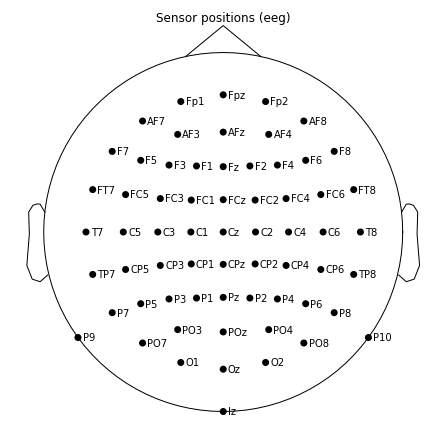

In [29]:
montage = mne.channels.make_standard_montage("biosemi64")
montage.plot();

Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:    2.4s


Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks


[Parallel(n_jobs=2)]: Done 2800 out of 2800 | elapsed:    4.6s finished


Selecting by number: 8 components
Fitting ICA took 4.6s.


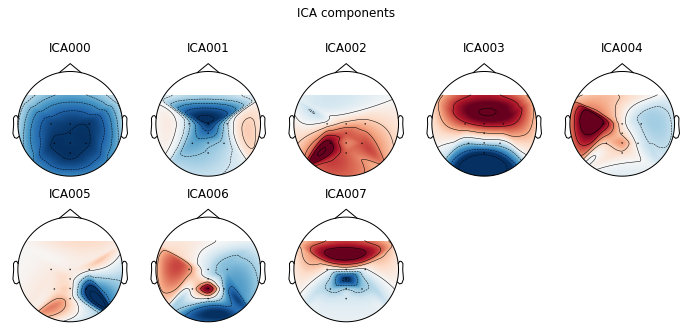

[<Figure size 702x339.12 with 8 Axes>]

In [30]:
montage = mne.channels.make_standard_montage("biosemi64")
mne_data.set_montage(montage)
mne_data.filter(1., 40., n_jobs=2, fir_design='firwin')
picks_eeg = mne.pick_types(mne_data.info, meg=False, eeg=True, eog=False,
                           stim=False, exclude='bads')
ica = ICA(n_components=8, method='fastica', random_state=23)
reject = dict(eeg=5e-12, grad=4000e-13)
ica.fit(mne_data, picks=picks_eeg, decim=3, reject=reject)
ica.plot_components()

    Using multitaper spectrum estimation with 7 DPSS windows
350 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
350 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
350 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
350 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
350 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
350 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
350 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
350 matching events found
No baseline corre

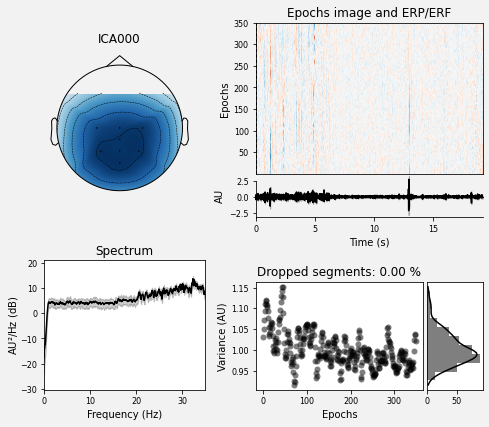

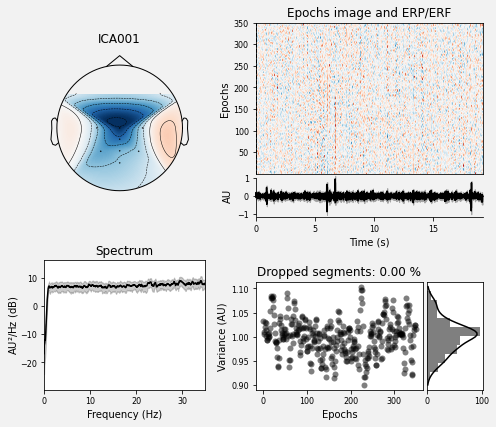

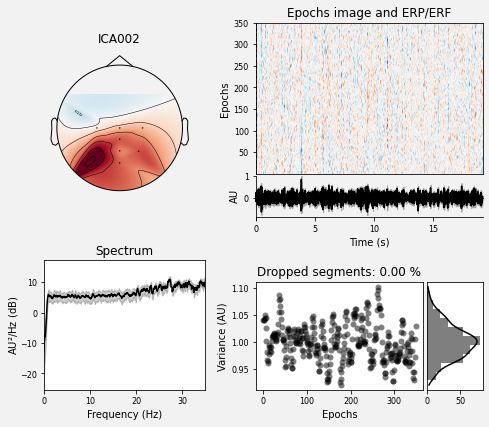

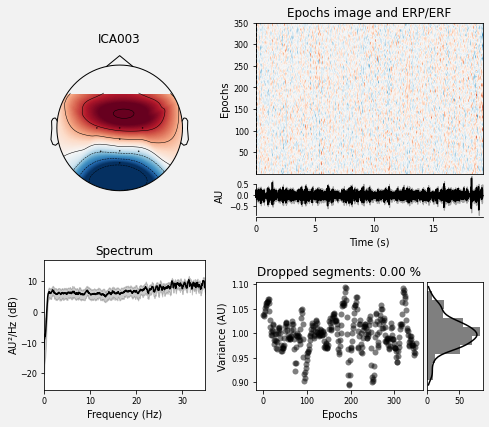

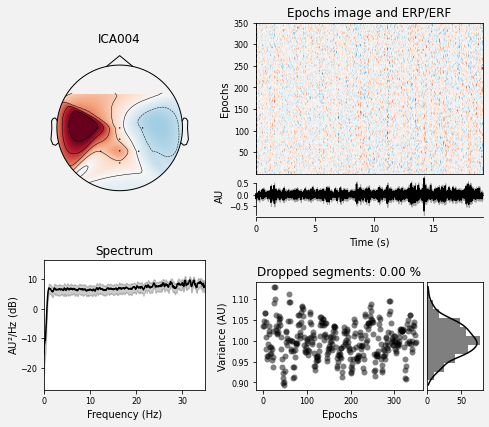

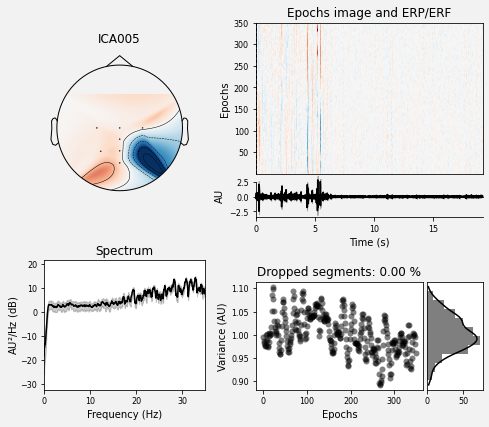

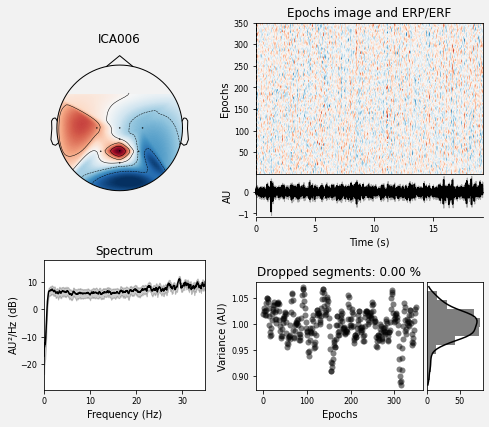

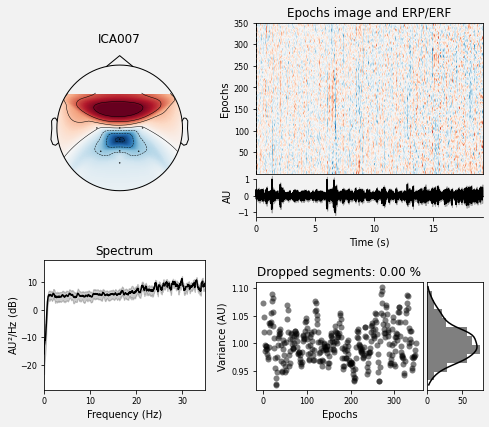

[<Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>]

In [31]:
ica.plot_properties(mne_data, picks=[0,1,2,3,4,5,6,7], psd_args={'fmax': 35.})

## 3.2 Histogram, изглед на сигналот и зависности помеѓу 8те канали
За хистограмот и зависноста меѓу 8те канали ќе ги искористиме податоците за првиот учесник од неговата прва сесија.

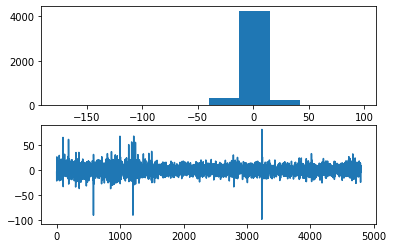

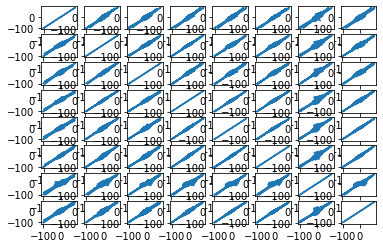

In [ ]:
fig, axs = plt.subplots(2)
axs[0].hist(data[2][49]) # Хистограм за третиот канал, педесетата епоха
axs[1].plot(range(0, 4800), data[2][175][0:4800]) # Вредноста на сигналот на третиот канал, во 175-тата епоха, во сите настани

k = 0
fig, axs = plt.subplots(8,8)
for i in range(8):
  for y in range(8):
    axs[i,y].plot(data[i][175], data[y][175])

## 3.3 Визуелизација на EEG сигналите во рамки на првиот настан (првата слика) и 50-тиот настан (втората слика)

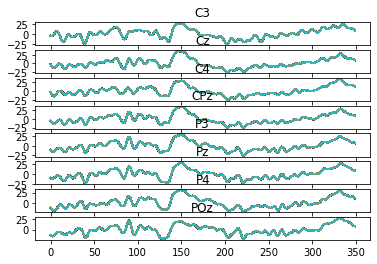

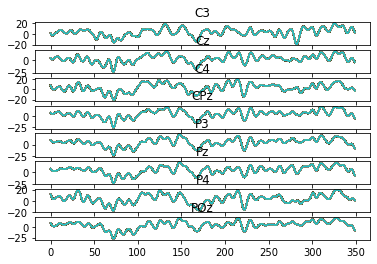

In [ ]:
reshaped_data = np.swapaxes(data, 1, 2) # (канал, настан, епоха).

fig, axs = plt.subplots(8)
for channel in range(0, 8):
  axs[channel].set_title(CH_NAMES[channel])
  for epoch in range(0, 350):
    axs[channel].plot(range(0,350), reshaped_data[channel][0])

fig, axs = plt.subplots(8)
for channel in range(0, 8):
  axs[channel].set_title(CH_NAMES[channel])
  for epoch in range(0, 350):
    axs[channel].plot(range(0,350), reshaped_data[channel][50])

## 3.4 Визуелизација на EEG сигналите во првата, средната и последната епоха.
1. Визуелизација на EEG податоците по канали за првата, средната и последната епоха.
2. Power Spectrum Density на 175-тата епоха. Во оваа епоха сигналите би биле најстабилни за објектот кој светка.

Creating RawArray with float64 data, n_channels=8, n_times=4800
    Range : 0 ... 4799 =      0.000 ...    19.196 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=4800
    Range : 0 ... 4799 =      0.000 ...    19.196 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=4800
    Range : 0 ... 4799 =      0.000 ...    19.196 secs
Ready.


====== 1 ======
Прва епоха од сите 4800 настани


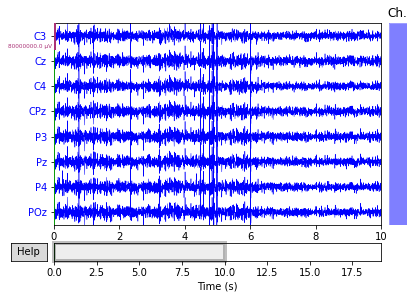

Средна епоха од сите 4800 настани


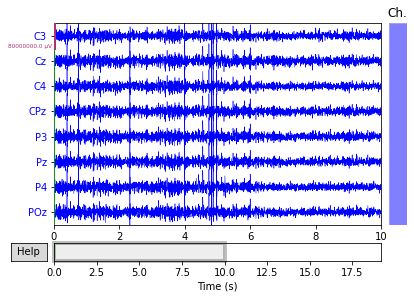

Последна епоха од сите 4800 настани


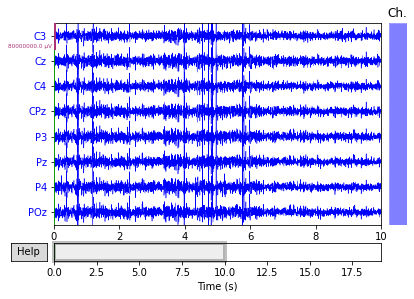



====== 2 ======
Effective window size : 8.192 (s)
350 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


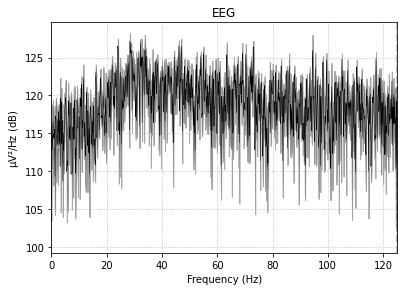

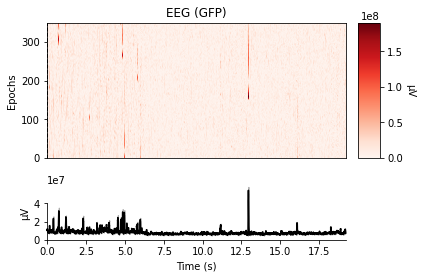

In [ ]:
middle_epoch = mne_compatible_array[175]
first_epoch = mne_compatible_array[0]
last_epoch = mne_compatible_array[349]

raw_middle = mne.io.RawArray(middle_epoch, MNE_INFO)
raw_first = mne.io.RawArray(first_epoch, MNE_INFO)
raw_last = mne.io.RawArray(last_epoch, MNE_INFO)

print("\n")
print(colored('====== 1 ======', 'red'))
print(colored("Прва епоха од сите 4800 настани", 'blue'))
raw_first.plot(n_channels=8, scalings=dict(eeg=40), title='EEG Signals',
         show=True, block=True, color = dict(eeg='blue'))
print(colored("Средна епоха од сите 4800 настани", 'blue'))
raw_middle.plot(n_channels=8, scalings=dict(eeg=40), title='EEG Signals',
         show=True, block=True, color = dict(eeg='blue'))
print(colored("Последна епоха од сите 4800 настани", 'blue'))
raw_last.plot(n_channels=8, scalings=dict(eeg=40), title='EEG Signals',
         show=True, block=True, color = dict(eeg='blue'))
print("\n")
print(colored('====== 2 ======', 'red'))
raw_middle.plot_psd(area_mode='range', show=False, average=True);
mne_data.plot_image();

## 3.5 Визуелна споредба на EEG податоците при светкање на првиот и последниот објект  
Во првиот случај вршиме споредба на EEG податоците кога првиот и последниот објект светнал без разлика дали бил target, додека во вториот случај ги споредуваме EEG податоците за случаи само кога тие објекти биле target објекти.

Creating RawArray with float64 data, n_channels=8, n_times=600
    Range : 0 ... 599 =      0.000 ...     2.396 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=300
    Range : 0 ... 299 =      0.000 ...     1.196 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=600
    Range : 0 ... 599 =      0.000 ...     2.396 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=300
    Range : 0 ... 299 =      0.000 ...     1.196 secs
Ready.



====== ПРВ ОБЈЕКТ - Книги на полица ======
Вкупно светнал: 600
Вкупно светнал и бил target: 300


====== ПОСЛЕДЕН ОБЈЕКТ - Слика закачена на ѕид ======
Вкупно светнал: 600
Вкупно светнал и бил target: 300


====== Графици со EEG податоци кога светнале првиот и последниот објект  ======


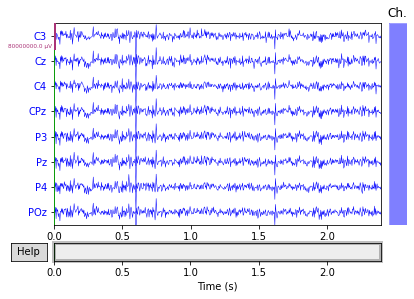

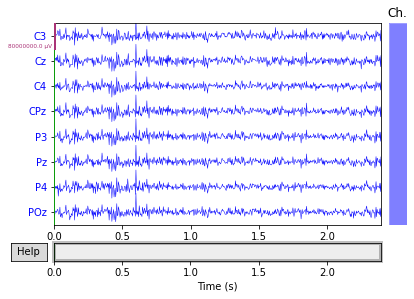



====== Графици со EEG податоци кога светнале првиот и последниот објект и биле target  ======


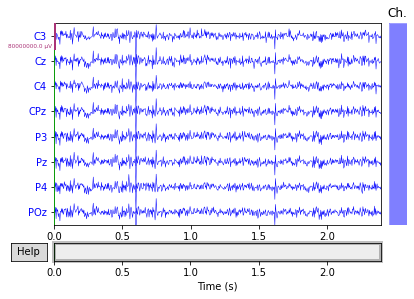

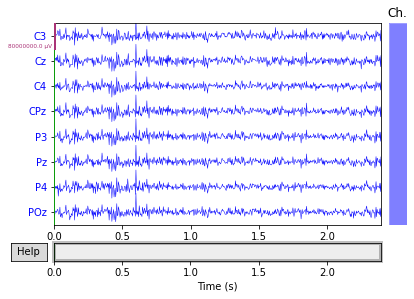

In [ ]:
# Извлекување на настаните каде светнал првиот објект.
first_object_events = [index for index, value in enumerate(events) if value == 0]
first_object_eeg_data = np.zeros((8, 350, len(first_object_events)))
for channel in range(0, 8): # Секој канал
  for epoch in range(0, 350): # Секоја епоха
    i = 0
    for event in first_object_events: # Настан
      first_object_eeg_data[channel][epoch][i] = data[channel][epoch][event]
      i = i+1

# Креирање на соодветна дводимензионална низа за mne библиотеката
mne_first_obj_array = np.swapaxes(first_object_eeg_data, 0, 1) # (епохa, канал, настан).
epoch = mne_first_obj_array[175] 
first_object_raw = mne.io.RawArray(epoch, MNE_INFO)





# Извлекување на настаните каде светнал првиот објект и бил target.
first_object_events_target = [index for index, value in enumerate(events) if value == 0]
for event_pos in first_object_events_target:
  if targets[event_pos] == 1:
    continue # Продолжи
  else:
    first_object_events_target.remove(event_pos) # Избриши -> Објектот не е target
first_object_target_eeg_data = np.zeros((8,350, len(first_object_events_target)))
for channel in range(0, 8): # Секој канал
  for epoch in range(0, 350): # Секоја епоха
    i = 0
    for event in first_object_events_target: # Настан
      first_object_target_eeg_data[channel][epoch][i] = data[channel][epoch][event]
      i = i+1

# Креирање на соодветна дводимензионална низа за mne библиотеката
mne_first_obj_target_array = np.swapaxes(first_object_target_eeg_data, 0, 1) # (епохa, канал, настан).
epoch = mne_first_obj_target_array[175] 
first_object_target_raw = mne.io.RawArray(epoch, MNE_INFO)





# Извлекување на настаните каде светнал последниот објект.
last_object_events = [index for index, value in enumerate(events) if value == 7]
last_object_eeg_data = np.zeros((8,350, len(last_object_events)))
for channel in range(0, 8): # Секој канал
  for epoch in range(0, 350): # Секоја епоха
    i = 0
    for event in last_object_events: # Настан
      last_object_eeg_data[channel][epoch][i] = data[channel][epoch][event]
      i = i+1

# Креирање на соодветна дводимензионална низа за mne библиотеката
mne_last_obj_array = np.swapaxes(last_object_eeg_data, 0, 1) # (епохa, канал, настан).
epoch = mne_last_obj_array[175] 
last_object_raw = mne.io.RawArray(epoch, MNE_INFO)





# Извлекување на настаните каде светнал последниот објект и бил target.
last_object_events_target = [index for index, value in enumerate(events) if value == 7]
for event_pos in last_object_events_target:
  if targets[event_pos] == 1:
    continue # Продолжи
  else:
    last_object_events_target.remove(event_pos) # Избриши -> Објектот не е target
last_object_target_eeg_data = np.zeros((8,350, len(last_object_events_target)))
for channel in range(0, 8): # Секој канал
  for epoch in range(0, 350): # Секоја епоха
    i = 0
    for event in last_object_events_target: # Настан
      last_object_target_eeg_data[channel][epoch][i] = data[channel][epoch][event]
      i = i+1
      
# Креирање на соодветна дводимензионална низа за mne библиотеката
mne_last_obj_target_array = np.swapaxes(last_object_target_eeg_data, 0, 1) # (епохa, канал, настан).
epoch = mne_last_obj_target_array[175] 
last_object_target_raw = mne.io.RawArray(epoch, MNE_INFO)





# Исцртување и печатење
print("\n\n")
print(colored('====== ПРВ ОБЈЕКТ - Книги на полица ======', 'red'))
print(colored("Вкупно светнал: " + str(len(first_object_events)), 'blue'))
print(colored("Вкупно светнал и бил target: " + str(len(first_object_events_target)), 'blue'))
print("\n")
print(colored('====== ПОСЛЕДЕН ОБЈЕКТ - Слика закачена на ѕид ======', 'red'))
print(colored("Вкупно светнал: " + str(len(last_object_events)), 'blue'))
print(colored("Вкупно светнал и бил target: " + str(len(last_object_events_target)), 'blue'))
print("\n")
print(colored('====== Графици со EEG податоци кога светнале првиот и последниот објект  ======', 'green'))
first_object_raw.plot(n_channels=8, scalings=dict(eeg=40), title='EEG Signals',
         show=True, block=True, color = dict(eeg='blue'));
last_object_raw.plot(n_channels=8, scalings=dict(eeg=40), title='EEG Signals',
         show=True, block=True, color = dict(eeg='blue'));
print("\n")
print(colored('====== Графици со EEG податоци кога светнале првиот и последниот објект и биле target  ======', 'green'))
first_object_raw.plot(n_channels=8, scalings=dict(eeg=40), title='EEG Signals',
         show=True, block=True, color = dict(eeg='blue'));
last_object_raw.plot(n_channels=8, scalings=dict(eeg=40), title='EEG Signals',
         show=True, block=True, color = dict(eeg='blue'));

    Using multitaper spectrum estimation with 7 DPSS windows


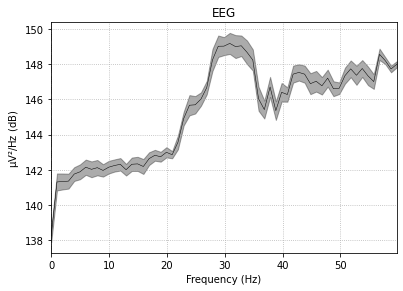

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 8 components
Fitting ICA took 13.2s.


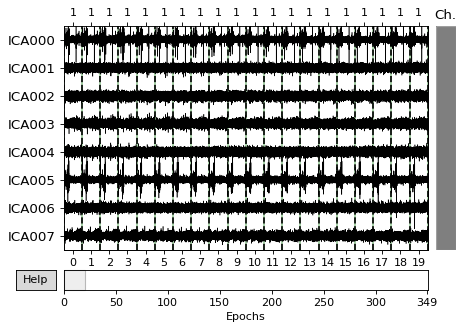

In [ ]:
mne_data.plot_psd(tmin=0.2, tmax=1.2, fmin=0, fmax=60, average=True, spatial_colors=False);
num_components = 8
ica = ICA(n_components=num_components, method='fastica')
ica.fit(mne_data)
ica.plot_sources(mne_data);

# (4) Функции за Претпроцесирање

In [8]:
#@title 4.1 Стандардизација на податоците
def standardize(mne_compatible_array): 
  standardizer = mne.decoding.Scaler(scalings='mean')
  standardizer.fit(mne_compatible_array)
  standardized_data = standardizer.transform(mne_compatible_array)
  print("(Стандардизација) Просекот е:",-round(standardized_data.mean()))
  print("(Стандардизација) Варијансата е:",round(standardized_data.var()))
  return standardized_data

In [9]:
#@title 4.2 Отстранување на шум
def noise_removal(mne_compatible_array, mne_data):
  Min, Max = round(mne_compatible_array.min()),round(mne_compatible_array.max())*1000000
  picks = mne.pick_types(mne_data.info, meg=False, eeg=True, stim=False, eog=False)
  # mne.viz.plot_epochs_image(mne_data, picks='eeg', vmin= Min, vmax=Max)
  
  xd = mne.preprocessing.Xdawn(n_components=2, signal_cov=None)
  xd.fit(mne_data)
  noise_removed_data = xd.apply(mne_data)
  # mne.viz.plot_epochs_image(epochs_denoised['1'], picks='eeg', vmin=Min, vmax=Max)
  print(noise_removed_data.keys().shape)
  print(noise_removed_data.shape)
  return noise_removed_data


In [10]:
#@title 4.3 Principal Component Analysis
def pca(mne_compatible_array, mne_data):
  Min, Max = round(mne_compatible_array.min()),round(mne_compatible_array.max())*1000000
  pca = mne.decoding.UnsupervisedSpatialFilter(PCA(8), average=False)
  pca_data = pca.fit_transform(mne_compatible_array)
  ev = mne.EvokedArray(np.mean(pca_data, axis=0),
                      mne.create_info(8, mne_data.info['sfreq'],
                                      ch_types='eeg'), tmin=Min)
  ev.plot(show=False, window_title="PCA", time_unit='ms')
  print(ev)
  return ev

# (5) Тренирање на моделот
Тренирање на моделот

Вчитување податоци од испитниот примерок (учесник) 3...
Податоците од испитниот примерок (учесник) 3 се вчитани.

350 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
(Стандардизација) Просекот е: -0.0
(Стандардизација) Варијансата е: 1.0
<Evoked  |  '' (average, N=1), [-78, -58.804] sec, 8 ch, ~320 kB>
Version 10
Version 10
Version 10
Version 10
Version 10
Version 10
Version 10
Train on 3600 samples, validate on 1200 samples
Epoch 1/150
3400/3600 [===========================>..] - ETA: 0s - loss: 2.3324 - acc: 0.1774
Epoch 00001: val_loss improved from inf to 2.37535, saving model to saved_models/weights.best.basic_mlp.hdf5
3600/3600 [==============================] - 8s 2ms/sample - loss: 2.3341 - acc: 0.1758 - val_loss: 2.3753 - val_acc: 0.1125
Epoch 2/150
3500/3600 [============================>.] - ETA: 0s - loss: 2.1601 - acc: 0.1966
Epoch 00002: val_loss improved from 2.37535 to 2.14999, saving model to s

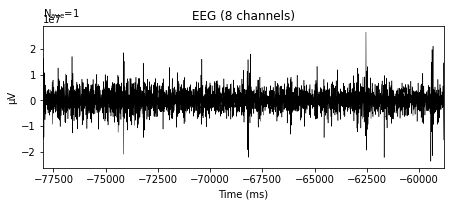

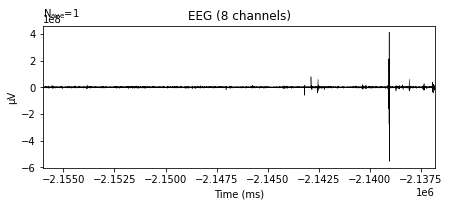

In [45]:
# Глобална низа каде ќе се зачувуваат тренираните модели
models = []

for participant in range(PARTICIPANT_START, PARTICIPANT_END):  # Итерација низ секој испитен примерок
    train_data, train_labels, train_events, train_targets = load_data(participant)
    
    # Примени функции за претпроцесирање
    mne_compatible_data = np.swapaxes(train_data, 0, 1)  # (епоха, канал, настан)
    mne_data = mne.epochs.EpochsArray(mne_compatible_data, MNE_INFO)
    preprocessed_data = standardize(mne_compatible_data)
    preprocessed_data = pca(mne_compatible_data, mne_data)
    # preprocessed_data = noise_removal(mne_compatible_data, mne_data)
    preprocessed_data = np.swapaxes(train_data, 0, 1) # (канал, епоха, настан)

    preprocessed_data = reshape(train_data) # Трансформирај во форма прифатлива за DeepConvNet

    X_train, X_test, y_train, y_test = train_test_split(preprocessed_data, train_labels, test_size=0.25, random_state=42)

    model = DeepConvNet(nb_classes = 8, Chans = 8, Samples = 350)
    model.compile(loss = 'categorical_crossentropy', metrics=['accuracy'],optimizer = Adam(0.0009))
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_mlp.hdf5', 
                                  verbose=1, save_best_only=True)

    y_train = to_cat(y_train)
    y_test = to_cat(y_test)

    model.fit(X_train, y_train, batch_size=NUM_BATCH_SIZE, epochs=NUM_EPOCHS, \
              validation_data=(X_test, y_test),callbacks=[checkpointer], verbose=1)

    score = model.evaluate(X_test, y_test, verbose=1)
    print(score)

    models.append(model)

# (6) Тестирање на моделот

Тестирање на моделот

In [47]:
# Иницијализација на променливите каде ќе бидат вчитани тест податоците
runs_per_block = [[i for i in range(3)] for j in range(15)] # Covek, Sesija
df = pd.read_csv('output_format.csv')

for participant in range(PARTICIPANT_START, PARTICIPANT_END): # Итерација низ секој испитен примерок
  print(f"============================================================ Учесник ({participant}) ============================================================")
  index = participant - PARTICIPANT_START 
  
  test_data, test_events = load_test_data(participant)
  runs_per_block = load_runs_per_block(participant)

  to_predict_data = reshape(test_data)
  predictions = models[index].predict(to_predict_data)

  print_test_data_info(participant, test_data, test_events, runs_per_block, predictions, index)

  int_pred = np.argmax(predictions, axis=1)
  int_ytest = np.argmax(y_test, axis=1)

  session_start = 0
  start_prediction_index = 0
  end_prediction_index = 0
  for session in range(0, 3):
    print(f"Сесија ({session}): ", end='')
    for block in range(0, 50):    
      events_per_block = runs_per_block[participant-1][session]

      start_prediction_index = session_start + (block*events_per_block)*8
      end_prediction_index = session_start + ((block+1)*events_per_block)*8

      block_prediction = int_pred[start_prediction_index:end_prediction_index]
      prediction = np.bincount(block_prediction).argmax() + 1
      df.iat[((participant-1)*3)+session, block+2] = prediction

      if (block != 49):
        print(str(prediction) + ",", end="")
      else:
        print(str(prediction))  
    session_start = end_prediction_index
  print(f"============================================================ Учесник ({participant}) ============================================================\n\n")

============================================================ Учесник (3) ============================================================
Вчитување тест податоци од испитниот примерок (учесник) 3...
Тест податоците од испитниот примерок (учесник) 3 се вчитани.

SBJ03| Test_data: (350, 7600)
SBJ03| Test_events: 7600
SBJ03 / S01| Runs per block: 6
SBJ03 / S02| Runs per block: 6
SBJ03 / S03| Runs per block: 7
SBJ03| Predictions: 7600

Сесија (0): 3,3,4,4,4,3,4,3,3,5,4,7,4,3,3,5,6,3,3,3,5,4,3,4,4,5,3,3,3,3,4,4,3,3,3,4,4,3,3,3,3,4,4,6,6,3,4,3,3,3
Сесија (1): 6,7,6,1,7,7,7,6,2,1,6,7,6,7,6,6,7,6,6,6,1,6,1,6,6,6,6,1,6,6,6,6,6,6,6,1,6,7,7,6,6,7,6,7,1,6,6,6,6,6
Сесија (2): 6,4,8,8,5,7,8,8,8,4,4,8,4,8,6,4,1,4,4,8,5,7,4,4,4,4,4,4,4,4,1,8,4,5,4,7,7,7,4,4,1,7,7,5,8,7,1,5,2,7
============================================================ Учесник (3) ============================================================


============================================================ Учесник (4) =======================

In [48]:
df

,SUBJECT,SESSION,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,Unnamed: 52
0,1,1,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,NaN
1,1,2,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,NaN
2,1,3,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,NaN
3,2,1,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,NaN
4,2,2,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,NaN
5,2,3,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,NaN
6,3,1,3,3,4,4,4,3,4,3,3,5,4,7,4,3,3,5,6,3,3,3,5,4,3,4,4,5,3,3,3,3,4,4,3,3,3,4,4,3,3,3,3,4,4,6,6,3,4,3,3,3,NaN
7,3,2,6,7,6,1,7,7,7,6,2,1,6,7,6,7,6,6,7,6,6,6,1,6,1,6,6,6,6,1,6,6,6,6,6,6,6,1,6,7,7,6,6,7,6,7,1,6,6,6,6,6,NaN
8,3,3,6,4,8,8,5,7,8,8,8,4,4,8,4,8,6,4,1,4,4,8,5,7,4,4,4,4,4,4,4,4,1,8,4,5,4,7,7,7,4,4,1,7,7,5,8,7,1,5,2,7,NaN
9,4,1,1,1,6,1,5,5,5,5,5,5,1,5,1,1,6,1,1,1,6,1,1,6,6,5,2,6,2,5,6,6,2,2,1,1,6,2,6,2,6,1,1,1,1,1,1,1,6,6,6,1,NaN
